<a href="https://colab.research.google.com/github/jjkcoding/Airplane-Prices/blob/main/Airplane_Prices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Google Colab to view the graphs!

In [1]:
# Install Libraries
!apt-get update -y &> /dev/null
!apt install chromium-chromedriver &> /dev/null
!cp /usr/lib/chromium-browser/chromedriver/usr/bin &> /dev/null
!pip install selenium &> /dev/null

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from selenium import webdriver
from datetime import datetime
from datetime import timedelta
from datetime import date

user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'

options = webdriver.ChromeOptions()
options.add_argument('-headless')
options.add_argument('-no-sandbox')
options.add_argument('-disable-dev-shm-usage')

options.add_argument(f'user-agent={user_agent}')

## Webscraping the Data:
Using "kayak.com", I am able to webscrape the current airline ticket prices within 330 days away of departure date. Whenever the kayak webpage loads, it will give from the previous 3 days to the next 3 days airline ticket prices from the selected departure date for the selected arrival date. For example, if I said I was departing on 9/15/2021 and coming back on 10/10/2021, kayak will give you all the 7 prices of departing from 9/12/2021 to 9/18/2021 for the arrival date 10/10/2021. 

I would first start from the beginning departure date and set a temporary arrival date to be 4 days after the selected departure date. An example would be getting data for the 7 prices of departing from 9/12/2021 to 9/18/2021 when the arrival date is 9/19/2021. Using this method, I would start from the selected arrival date and end at the selected departure ending date by iterating 4 days higher than the previous iteration. Because kayak is only able to get 330 days of data into the future, I was not able to get a years worth of data.

In [ ]:
# Grabs the data from the kayak website
def webscrape_data(beg_str, end_str, airport_from, airport_to):
  kayak_web = ('https://www.kayak.com/flights/' + airport_from + '-' + airport_to +
             '/' + beg_str + '-flexible/' + end_str + '?sort=bestflight_a')
  wd.get(kayak_web)
  sleep(50)
  data_text = wd.find_element_by_xpath("//div[@style='flex:7']/div[@role='rowgroup']").text
  return data_text.split('\n')

# Add the new data into the current dataframe
def update_df(depart_date, arrive_date, airport_from, airport_to, money_to_int, df):
  for i in range(0, len(money_to_int)):
    cur_day = depart_date + timedelta(days = -3 + i)
    new_row = {'Depart_Airport':airport_from, 'Arrive_Airport':airport_to, 
               'Depart_Date':cur_day, 'Arrival_Date':arrive_date, 
               'Depart_Day_Type':cur_day.strftime('%A'), 
               'Arrive_Day_Type':arrive_date.strftime('%A'), 
               'Cost':money_to_int[i]}
    df = df.append(new_row, ignore_index = True)
  return df

# Gather info from every four days
def gather_info_every_four(depart_date, arrive_date, airport_from, airport_to, df):
  cur_arrive_date = depart_date + timedelta(days = 4)
  while depart_date < arrive_date:
    money_vals = webscrape_data(depart_date.strftime("%Y-%m-%d"), 
                                cur_arrive_date.strftime("%Y-%m-%d"), 
                                airport_from, 
                                airport_to)[:min((arrive_date - depart_date).days + 3, 7)]
    money_to_int = list(map(lambda x: int(x[1:].replace(",","")), money_vals))
    df = update_df(depart_date, cur_arrive_date, airport_from, airport_to, money_to_int, df)
    df.to_excel("final_update.xlsx")
    depart_date += timedelta(days = 4)
    cur_arrive_date += timedelta(days=4)
  return df 

## Start the Data Collection:
In this data collect, I gathered the data starting from the departure date of 9/3/2021 and last arrival date of 6/28/2022. I would start the simulation 4 days after the current day, because kayak gives the prices of the previous 3 days from the selected departure date. Airline prices that have already flown are not listed on the kayak website.

Because the web scraping takes a long time and sometimes breaksdown midway, I would save the data into "final_update.xlsx". Then, I would rerun the simulation using the commented section code below to continue the webscraping. 

In [ ]:
wd = webdriver.Chrome('chromedriver',options=options)
sleep(2)

depart_date = date.today() + timedelta(days = 4)
arrive_date = depart_date + timedelta(days = 295)
airport_from = 'LAX'
airport_to = 'SEL'

air_dat = pd.DataFrame()
air_dat = gather_info_every_four(depart_date, arrive_date, airport_from, airport_to, air_dat)

In [ ]:
# In case the code breaks midway
# depart_date = pd.to_datetime('2022-03-24').date()
# air_dat = pd.read_excel("/content/final_update.xlsx", index_col = 0)
# air_dat = air_dat[['Depart_Airport', 'Arrive_Airport', 'Depart_Date', 'Arrival_Date', 'Depart_Day_Type', 'Arrive_Day_Type', 'Cost']]

# air_dat = gather_info_every_four(depart_date, arrive_date, airport_from, airport_to, air_dat)

## Start Analysis!

In [2]:
# Representation of the collected data
air_dat = pd.read_excel("/content/final_update.xlsx", index_col = 0)
air_dat = air_dat[['Depart_Airport', 'Arrive_Airport', 'Depart_Date', 'Arrival_Date', 'Depart_Day_Type', 'Arrive_Day_Type', 'Cost']]
air_dat

,Depart_Airport,Arrive_Airport,Depart_Date,Arrival_Date,Depart_Day_Type,Arrive_Day_Type,Cost
0,LAX,SEL,2021-09-03,2021-09-10,Friday,Friday,1264
1,LAX,SEL,2021-09-04,2021-09-10,Saturday,Friday,1223
2,LAX,SEL,2021-09-05,2021-09-10,Sunday,Friday,1217
3,LAX,SEL,2021-09-06,2021-09-10,Monday,Friday,1181
4,LAX,SEL,2021-09-07,2021-09-10,Tuesday,Friday,1217
...,...,...,...,...,...,...,...
508,LAX,SEL,2022-06-23,2022-06-28,Thursday,Tuesday,1077
509,LAX,SEL,2022-06-24,2022-06-28,Friday,Tuesday,1022
510,LAX,SEL,2022-06-25,2022-06-28,Saturday,Tuesday,1094
511,LAX,SEL,2022-06-26,2022-06-28,Sunday,Tuesday,1085


In [3]:
# Creating the difference in departure to arrival dates, departure month and arrival month
air_dat = air_dat.assign(Day_Diff = lambda x: (x.Arrival_Date - x.Depart_Date).dt.days)
air_dat['Depart_Month'] = list(map(lambda x: x.month, air_dat['Depart_Date']))
air_dat['Arrival_Month'] = list(map(lambda x: x.month, air_dat['Arrival_Date']))
air_dat

,Depart_Airport,Arrive_Airport,Depart_Date,Arrival_Date,Depart_Day_Type,Arrive_Day_Type,Cost,Day_Diff,Depart_Month,Arrival_Month
0,LAX,SEL,2021-09-03,2021-09-10,Friday,Friday,1264,7,9,9
1,LAX,SEL,2021-09-04,2021-09-10,Saturday,Friday,1223,6,9,9
2,LAX,SEL,2021-09-05,2021-09-10,Sunday,Friday,1217,5,9,9
3,LAX,SEL,2021-09-06,2021-09-10,Monday,Friday,1181,4,9,9
4,LAX,SEL,2021-09-07,2021-09-10,Tuesday,Friday,1217,3,9,9
...,...,...,...,...,...,...,...,...,...,...
508,LAX,SEL,2022-06-23,2022-06-28,Thursday,Tuesday,1077,5,6,6
509,LAX,SEL,2022-06-24,2022-06-28,Friday,Tuesday,1022,4,6,6
510,LAX,SEL,2022-06-25,2022-06-28,Saturday,Tuesday,1094,3,6,6
511,LAX,SEL,2022-06-26,2022-06-28,Sunday,Tuesday,1085,2,6,6


## Does it matter if you depart or arrive on a certain day type?

NO. Across the different day types of departing/arriving, there does not seem to be a specific day type that has an overall cost that is much higher or lower than the other day types. They all have roughly a mean cost around $1000 for all day types and the quartiles are roughly similar in range. 

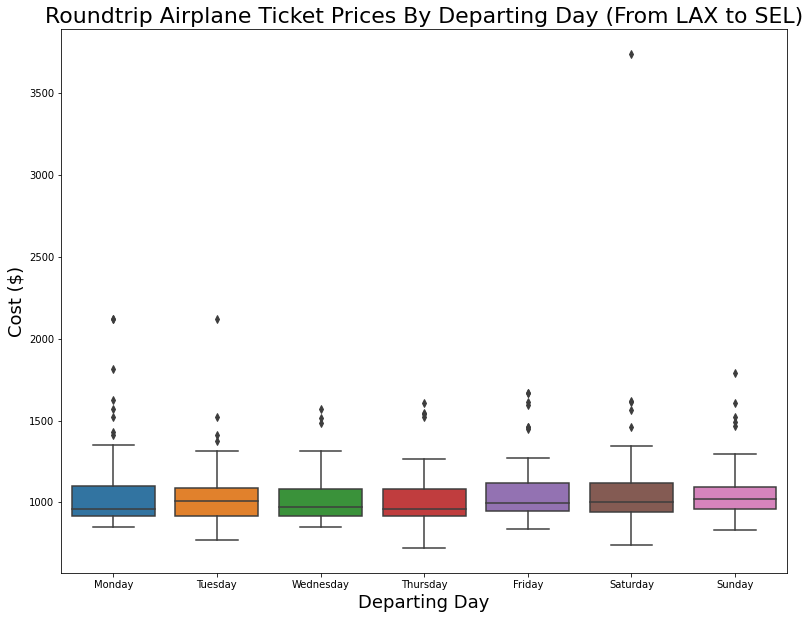

In [4]:
week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(13, 10))
sns.boxplot(x = 'Depart_Day_Type', y = 'Cost', order = week_order, data = air_dat, notch = False)

plt.title("Roundtrip Airplane Ticket Prices By Departing Day (From LAX to SEL)", size = 22)
plt.xlabel("Departing Day", size = 18)
plt.ylabel("Cost ($)", size = 18)
plt.show()

## Does it matter how long the trip is?

YES. Based on data below, it is much more expensive to purchase a 1 day trip. The data also shows that a 4 day trip is slightly lower in price compared to the other day differences. Therefore, if you want to travel to Korea from California, it is recommended to take a four day trip for a low price.

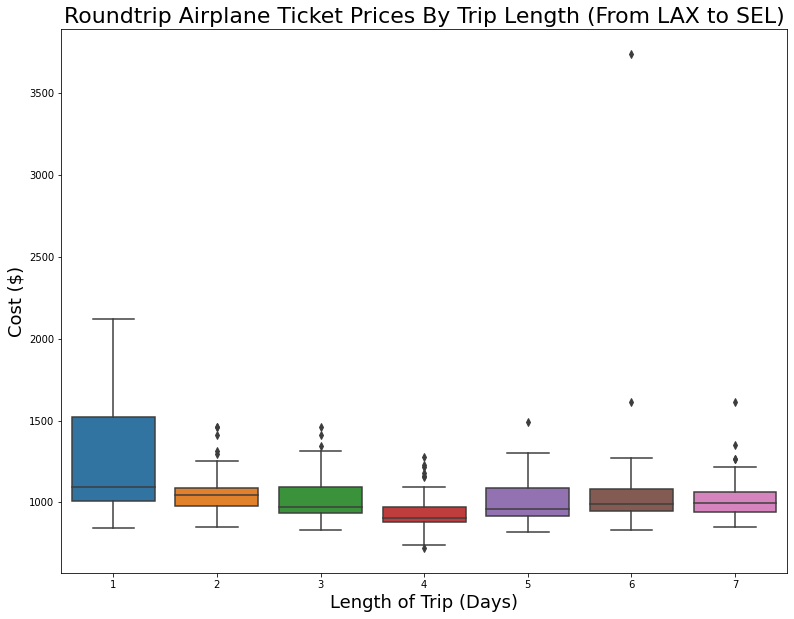

In [5]:
plt.figure(figsize=(13, 10))
sns.boxplot(x = 'Day_Diff', y = 'Cost',  data = air_dat, notch = False)

plt.title("Roundtrip Airplane Ticket Prices By Trip Length (From LAX to SEL)", size = 22)
plt.xlabel("Length of Trip (Days)", size = 18)
plt.ylabel("Cost ($)", size = 18)
plt.show()

## Further Analysis in Day Type and Length of Trip:
Based on the boxplots below, trips from California to Korea are most expensive if you depart on Monday for a 1-day trip. Departing for a 4-day trip continues to look like the cheapest option. Out of the 4-day trip departures, Thursday seems to be the best option for a depart day type. However, there are a few outliers, so Saturday may be a better option.

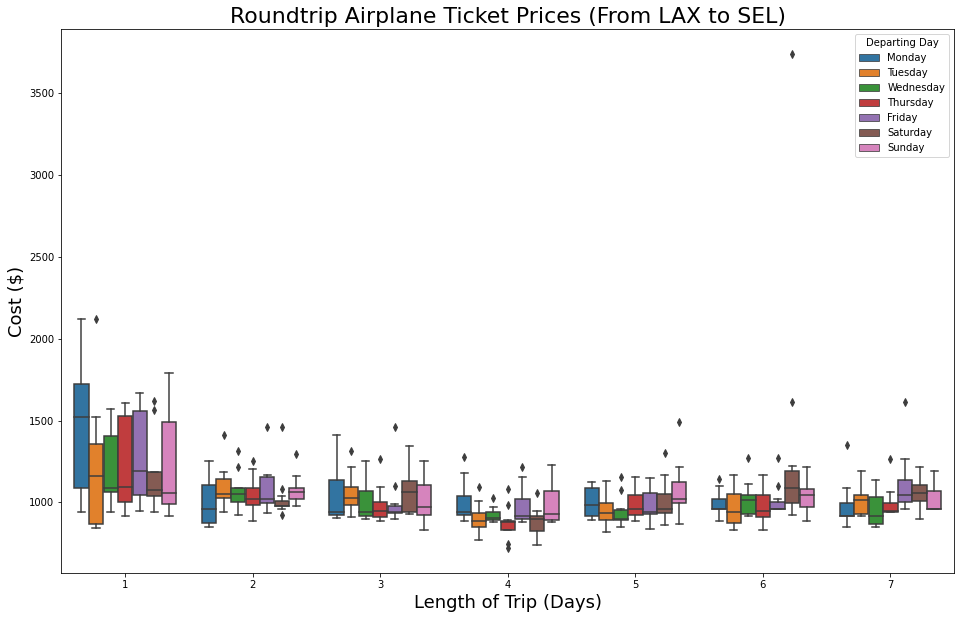

In [6]:
plt.figure(figsize=(16, 10))
sns.boxplot(x = 'Day_Diff', y = 'Cost', data = air_dat, hue = 'Depart_Day_Type', hue_order = week_order)

plt.title("Roundtrip Airplane Ticket Prices (From LAX to SEL)", size = 22)
plt.xlabel("Length of Trip (Days)", size = 18)
plt.ylabel("Cost ($)", size = 18)
plt.legend(title = 'Departing Day')
plt.show()

## Does it matter what month I depart?

YES. Based on the data alone, departing on December for a trip to Korea has a much higher cost than the other months. This is most likely due people visiting or coming back home for Winter break, Christmas, and New Years. Another holiday famous for leaving is Summer. Departing on June also has a higher cost compared to the other months most likely due to Summer break. It shows that September also has a higher cost compared to the other months, but I think this is because airplane price tickets are signficantly higher if purchased within the first month of purchase. Therefore, it is recommended to depart on any other month than December and June to get a price of around $1000.

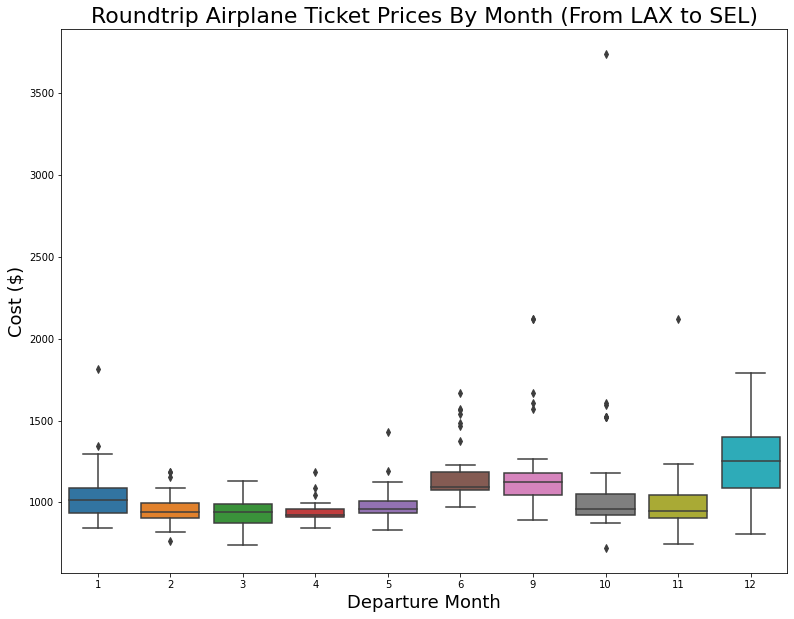

In [7]:
plt.figure(figsize=(13, 10))
sns.boxplot(x = 'Depart_Month', y = 'Cost',  data = air_dat, notch = False)

plt.title("Roundtrip Airplane Ticket Prices By Month (From LAX to SEL)", size = 22)
plt.xlabel("Departure Month", size = 18)
plt.ylabel("Cost ($)", size = 18)
plt.show()

## Further Analysis on Departure Month and Length of Trip
Because both the month and length of trip show signs of affecting the price of tickets, I wanted to see if including both in a graph would show new results. Something new found from this boxplot is that a 1-day trip on September (within the first month of getting a ticket) is much more expensive than any other boxplot. Therefore, you should not get a 1-day trip to Korea within the first month of purchasing the ticket. 

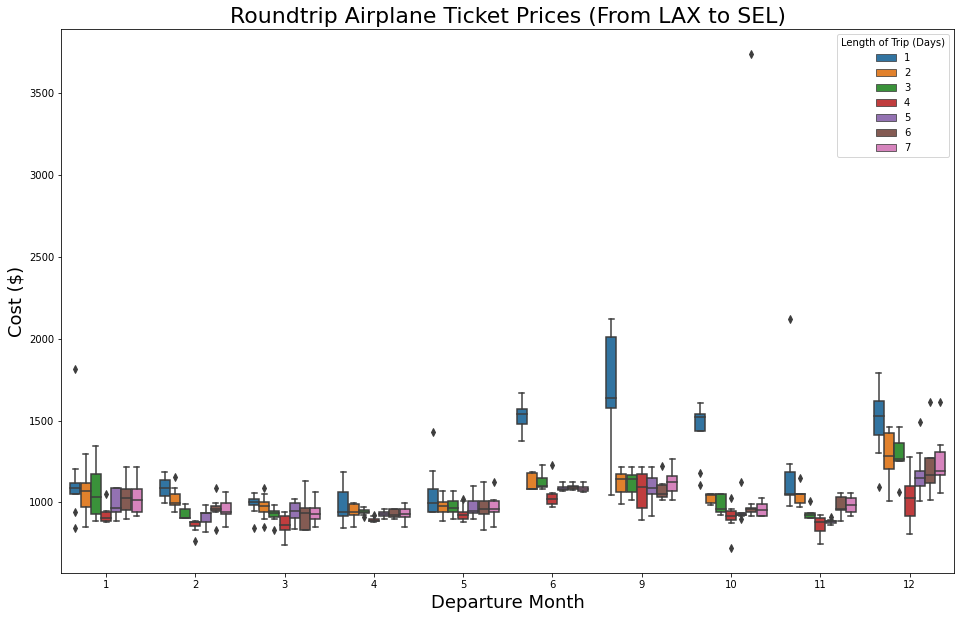

In [8]:
plt.figure(figsize=(16, 10))
sns.boxplot(x = 'Depart_Month', y = 'Cost', data = air_dat, hue = 'Day_Diff')

plt.title("Roundtrip Airplane Ticket Prices (From LAX to SEL)", size = 22)
plt.xlabel("Departure Month", size = 18)
plt.ylabel("Cost ($)", size = 18)
plt.legend(title = 'Length of Trip (Days)')
plt.show()